# 04 — Tracking con Optical Flow en SportsMOT 🌊🧵

En este notebook:

- Partimos de las **detecciones YOLO** ya generadas (CSV en `data/detections_yolo/`).
- Implementamos un tracker que combina:

  1. **Flujo óptico denso (Farnebäck)** entre frames consecutivos.
  2. **IoU** entre las bboxes *predichas* por flujo y las detecciones actuales.

- La idea: reducir cambios de ID y mejorar la consistencia temporal vs. un tracker de IoU puro.
- Evaluamos la calidad del tracking con `motmetrics` (MOTA, MOTP, IDF1, etc.).


## 1. Imports y rutas  📁 

In [19]:
from pathlib import Path
import configparser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import motmetrics as mm

plt.rcParams["figure.figsize"] = (10, 7)

# Detectar raíz del proyecto y carpetas
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_ROOT = PROJECT_ROOT / "data"

DATASET_ROOT = DATA_ROOT / "dataset"
SPLITS_DIR = DATA_ROOT / "splits_txt"
DETS_DIR = DATA_ROOT / "detections_yolo"

VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
    print("PROJECT_ROOT:", PROJECT_ROOT)
    print("DATA_ROOT:", DATA_ROOT)
    print("DATASET_ROOT:", DATASET_ROOT)
    print("SPLITS_DIR:", SPLITS_DIR)
    print("DETS_DIR:", DETS_DIR)


## 2. Elegir detecciones y secuencia 📄 

Tomamos el primer CSV, al igual que en el notebook 03

In [20]:
det_files = sorted(DETS_DIR.glob("*.csv"))
if not det_files:
    raise FileNotFoundError(f"No se encontraron CSV de detecciones en {DETS_DIR}")

det_csv_path = det_files[0]
print("Usaremos detecciones de:", det_csv_path.name)

# Inferir nombre de la secuencia a partir del nombre del archivo
stem = det_csv_path.stem  # ej: "v_XXXX_c009_yolov8n_step5"
seq_name = stem.split("_yol")[0]  # más robusto que "_yolo" (por si cambias modelo)
print("Nombre de secuencia inferido:", seq_name)

SEQ_DIR = DATASET_ROOT / "train" / seq_name
VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("SEQ_DIR:", SEQ_DIR)


Usaremos detecciones de: v_-6Os86HzwCs_c009_yolov8n_step1.csv
Nombre de secuencia inferido: v_-6Os86HzwCs_c009


##  3. Cargar GT, detecciones y frames 🧩

In [21]:
def load_gt(seq_dir: Path) -> pd.DataFrame:
    gt_path = seq_dir / "gt" / "gt.txt"
    cols = ["frame", "id", "x", "y", "w", "h", "conf", "cls", "vis"]
    return pd.read_csv(gt_path, header=None, names=cols)

gt_df = load_gt(SEQ_DIR)
gt_df.head()


,frame,id,x,y,w,h,conf,cls,vis
0,1,0,102,271,43,116,1,1,1
1,1,1,211,403,110,138,1,1,1
2,1,2,297,449,88,129,1,1,1
3,1,3,110,248,34,104,1,1,1
4,1,4,383,257,55,91,1,1,1


In [22]:
det_df = pd.read_csv(det_csv_path)
det_df.head()


,sequence,frame,x,y,w,h,conf,cls_id,cls_name
0,v_-6Os86HzwCs_c009,1,458.181396,496.385742,56.650757,97.304443,0.788891,0,person
1,v_-6Os86HzwCs_c009,1,1035.492676,371.656799,64.161133,120.854004,0.783783,0,person
2,v_-6Os86HzwCs_c009,1,104.503922,245.641418,40.465927,134.354858,0.616957,0,person
3,v_-6Os86HzwCs_c009,1,859.708618,278.640381,33.150146,91.484558,0.616271,0,person
4,v_-6Os86HzwCs_c009,1,226.590363,402.199585,72.834412,127.796204,0.578812,0,person


Listamos frames de la secuencia

In [23]:
def parse_seqinfo(seq_dir: Path) -> dict:
    ini_path = seq_dir / "seqinfo.ini"
    config = configparser.ConfigParser()
    config.read(ini_path)
    seq = config["Sequence"]
    return {
        "name": seq.get("name", seq_dir.name),
        "im_width": int(seq.get("imWidth")),
        "im_height": int(seq.get("imHeight")),
        "seq_length": int(seq.get("seqLength")),
        "fps": float(seq.get("frameRate")),
        "img_dir": seq.get("imDir", "img1"),
    }

seqinfo = parse_seqinfo(SEQ_DIR)
img_dir = SEQ_DIR / seqinfo["img_dir"]

all_frame_paths = sorted(
    [p for p in img_dir.iterdir() if p.suffix.lower() in (".jpg", ".png")]
)

examples = [p.name for p in all_frame_paths[:5]]

print(f"Nº de frames en {seq_name}: {len(all_frame_paths)}")
print("Ejemplos:", examples)


Nº de frames en v_-6Os86HzwCs_c009: 500
Ejemplos: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


## 4. Utilidades: IoU y conversión de cajas 📐

In [24]:
def xywh_to_xyxy(boxes):
    """
    boxes: array (N, 4) con columnas [x, y, w, h]
    devuelve (N, 4) con [x1, y1, x2, y2]
    """
    boxes = np.asarray(boxes)
    if boxes.size == 0:
        return np.zeros((0, 4), dtype=float)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    return np.stack([x1, y1, x2, y2], axis=1)


def iou_matrix(tracks_boxes, det_boxes):
    """
    tracks_boxes: (T, 4)
    det_boxes: (D, 4)
    devuelve matriz (T, D) con IoU.
    """
    if len(tracks_boxes) == 0 or len(det_boxes) == 0:
        return np.zeros((len(tracks_boxes), len(det_boxes)), dtype=float)

    tb = xywh_to_xyxy(tracks_boxes)
    db = xywh_to_xyxy(det_boxes)

    T = tb.shape[0]
    D = db.shape[0]
    ious = np.zeros((T, D), dtype=float)

    for t in range(T):
        x1_t, y1_t, x2_t, y2_t = tb[t]
        area_t = (x2_t - x1_t) * (y2_t - y1_t)
        for d in range(D):
            x1_d, y1_d, x2_d, y2_d = db[d]

            xx1 = max(x1_t, x1_d)
            yy1 = max(y1_t, y1_d)
            xx2 = min(x2_t, x2_d)
            yy2 = min(y2_t, y2_d)

            w = max(0.0, xx2 - xx1)
            h = max(0.0, yy2 - yy1)
            inter = w * h
            area_d = (x2_d - x1_d) * (y2_d - y1_d)
            union = area_t + area_d - inter

            ious[t, d] = inter / union if union > 0 else 0.0
    return ious


## 5. Flujo óptico Farnebäck + predicción de bbox 🌊

Vamos a:

- Para cada par de frames (f-1, f), calcular flujo denso flow con cv2.calcOpticalFlowFarneback.
- Para cada track activo cuyo último frame es f-1, calcular el desplazamiento medio dentro de su bbox.
- Desplazar la bbox con ese promedio para obtener la bbox predicha en el frame actual.

In [25]:
def compute_dense_flow(prev_gray, curr_gray):
    """
    Calcula flujo óptico denso entre dos imágenes en escala de grises
    usando Farnebäck.
    Devuelve array (H, W, 2) con (flow_x, flow_y).
    """
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, curr_gray,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0,
    )
    return flow


def predict_bbox_with_flow(flow, bbox):
    """
    Dada la matriz de flujo (H, W, 2) y una bbox [x, y, w, h] en la imagen anterior,
    estima una nueva bbox en la imagen actual desplazando según el promedio
    del flujo dentro de esa bbox.
    """
    H, W, _ = flow.shape
    x, y, w, h = bbox
    x1 = int(max(0, x))
    y1 = int(max(0, y))
    x2 = int(min(W - 1, x + w))
    y2 = int(min(H - 1, y + h))

    if x2 <= x1 or y2 <= y1:
        # bbox vacía o fuera de rango
        return bbox

    flow_crop = flow[y1:y2, x1:x2, :]  # (h, w, 2)
    if flow_crop.size == 0:
        return bbox

    # Desplazamiento promedio dentro de la caja
    dx = np.mean(flow_crop[..., 0])
    dy = np.mean(flow_crop[..., 1])

    x_new = x + dx
    y_new = y + dy

    return np.array([x_new, y_new, w, h], dtype=float)


## 6. Tracker IoU + Optical Flow 🧵

Este tracker es similar al IoU básico, pero:

- Cuando pasamos del frame f-1 al f, usamos flujo óptico para predecir bbox de cada track.
- La IoU se calcula entre esa bbox predicha y las detecciones del frame f.

In [26]:
def track_with_optical_flow(det_df: pd.DataFrame,
                            seq_dir: Path,
                            iou_thresh: float = 0.3,
                            max_age: int = 30):
    """
    Tracker basado en:
      - Flujo óptico Farnebäck entre frames consecutivos.
      - Matching greedy por IoU entre bboxes predichas y detecciones.
    det_df debe tener: sequence, frame, x, y, w, h, conf, cls_id, cls_name

    Devuelve DataFrame con:
      frame, id, x, y, w, h, conf, cls_id, cls_name
    """

    det_df = det_df.sort_values(["frame", "conf"], ascending=[True, False])
    frames = sorted(det_df["frame"].unique())

    # Mapear frame_id -> ruta de imagen
    img_dir = seq_dir / "img1"
    frame_id_to_path = {}
    for p in img_dir.iterdir():
        if p.suffix.lower() not in (".jpg", ".png"):
            continue
        fid = int(p.stem)
        frame_id_to_path[fid] = p

    next_track_id = 1
    active_tracks = {}  # track_id -> dict(bbox, last_frame, age)
    results = []

    prev_frame_id = None
    prev_gray = None
    prev_flow = None

    for frame in tqdm(frames, desc="Tracking OF+IoU"):
        dets_frame = det_df[det_df["frame"] == frame]
        det_boxes = dets_frame[["x", "y", "w", "h"]].values
        det_confs = dets_frame["conf"].values
        det_cls_ids = dets_frame["cls_id"].values
        det_cls_names = dets_frame["cls_name"].values
        det_idx = np.arange(len(dets_frame))

        # Actualizar edad de tracks
        for tid in list(active_tracks.keys()):
            active_tracks[tid]["age"] += 1

        # Leer imagen actual y calcular flujo respecto al frame anterior (si existe)
        curr_path = frame_id_to_path.get(frame, None)
        if curr_path is None:
            print(f"⚠ No se encontró imagen para frame {frame}")
            curr_gray = None
            flow = None
        else:
            curr_bgr = cv2.imread(str(curr_path))
            curr_gray = cv2.cvtColor(curr_bgr, cv2.COLOR_BGR2GRAY)

            if prev_gray is not None and prev_frame_id is not None and frame == prev_frame_id + 1:
                flow = compute_dense_flow(prev_gray, curr_gray)
            else:
                flow = None  # no flujo válido (salto de frame o primer frame)

        if len(active_tracks) == 0 or len(det_boxes) == 0:
            # No hay tracks activos o no hay detecciones: crear tracks nuevos
            for i in range(len(det_boxes)):
                tid = next_track_id
                next_track_id += 1
                active_tracks[tid] = {
                    "bbox": det_boxes[i],
                    "last_frame": frame,
                    "age": 0,
                }
                results.append({
                    "frame": frame,
                    "id": tid,
                    "x": det_boxes[i][0],
                    "y": det_boxes[i][1],
                    "w": det_boxes[i][2],
                    "h": det_boxes[i][3],
                    "conf": det_confs[i],
                    "cls_id": det_cls_ids[i],
                    "cls_name": det_cls_names[i],
                })
        else:
            # Tenemos tracks y detecciones => hacer matching
            track_ids = list(active_tracks.keys())

            # Predicción de bbox para cada track usando flujo si aplica
            pred_boxes = []
            for tid in track_ids:
                state = active_tracks[tid]
                bbox_prev = state["bbox"]
                if flow is not None and state["last_frame"] == (frame - 1):
                    bbox_pred = predict_bbox_with_flow(flow, bbox_prev)
                else:
                    bbox_pred = bbox_prev  # sin flujo, usamos bbox anterior
                pred_boxes.append(bbox_pred)
            pred_boxes = np.array(pred_boxes)

            # Matriz IoU entre bboxes predichas y detecciones actuales
            ious = iou_matrix(pred_boxes, det_boxes)
            T, D = ious.shape

            matched_tracks = set()
            matched_dets = set()

            pairs = [
                (ious[t, d], t, d)
                for t in range(T)
                for d in range(D)
            ]
            pairs.sort(reverse=True, key=lambda x: x[0])

            for iou, t_idx, d_idx in pairs:
                if iou < iou_thresh:
                    break
                if t_idx in matched_tracks or d_idx in matched_dets:
                    continue

                matched_tracks.add(t_idx)
                matched_dets.add(d_idx)

                tid = track_ids[t_idx]
                active_tracks[tid]["bbox"] = det_boxes[d_idx]
                active_tracks[tid]["last_frame"] = frame
                active_tracks[tid]["age"] = 0

                results.append({
                    "frame": frame,
                    "id": tid,
                    "x": det_boxes[d_idx][0],
                    "y": det_boxes[d_idx][1],
                    "w": det_boxes[d_idx][2],
                    "h": det_boxes[d_idx][3],
                    "conf": det_confs[d_idx],
                    "cls_id": det_cls_ids[d_idx],
                    "cls_name": det_cls_names[d_idx],
                })

            # Detecciones sin track asignado -> nuevos tracks
            for d_idx in det_idx:
                if d_idx not in matched_dets:
                    tid = next_track_id
                    next_track_id += 1
                    active_tracks[tid] = {
                        "bbox": det_boxes[d_idx],
                        "last_frame": frame,
                        "age": 0,
                    }
                    results.append({
                        "frame": frame,
                        "id": tid,
                        "x": det_boxes[d_idx][0],
                        "y": det_boxes[d_idx][1],
                        "w": det_boxes[d_idx][2],
                        "h": det_boxes[d_idx][3],
                        "conf": det_confs[d_idx],
                        "cls_id": det_cls_ids[d_idx],
                        "cls_name": det_cls_names[d_idx],
                    })

            # Matar tracks demasiado viejos
            for tid in list(active_tracks.keys()):
                if active_tracks[tid]["age"] > max_age:
                    del active_tracks[tid]

        # Actualizar gris previo
        prev_gray = curr_gray
        prev_frame_id = frame

    tracks_df = pd.DataFrame(results)
    return tracks_df



## 7. Ejecutar tracker con Optical Flow 🚀

In [27]:
tracks_of_df = track_with_optical_flow(det_df, SEQ_DIR, iou_thresh=0.3, max_age=30)
tracks_of_df.head()

Tracking OF+IoU: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s]


,frame,id,x,y,w,h,conf,cls_id,cls_name
0,1,1,458.181396,496.385742,56.650757,97.304443,0.788891,0,person
1,1,2,1035.492676,371.656799,64.161133,120.854004,0.783783,0,person
2,1,3,104.503922,245.641418,40.465927,134.354858,0.616957,0,person
3,1,4,859.708618,278.640381,33.150146,91.484558,0.616271,0,person
4,1,5,226.590363,402.199585,72.834412,127.796204,0.578812,0,person


## Filtrado de balón (sports ball) 🏀
Seleccionamos únicamente las detecciones/tracklets del balón para revisar su cobertura.

In [ ]:
BALL_CLASSES = {"sports ball", "ball", "basketball", "volleyball"}

ball_tracks_df = tracks_of_df[tracks_of_df["cls_name"].astype(str).str.lower().isin({c.lower() for c in BALL_CLASSES})]
print(f"Tracks totales: {len(tracks_of_df)} | Tracks balón: {len(ball_tracks_df)}")
ball_tracks_df.head()


Guardar resultados en data/tracks_of/


In [28]:
TRACKS_OF_DIR = DATA_ROOT / "tracks_of"
TRACKS_OF_DIR.mkdir(parents=True, exist_ok=True)

tracks_of_path = TRACKS_OF_DIR / f"{seq_name}_of_ioutracker.csv"
tracks_of_df.to_csv(tracks_of_path, index=False)

VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("Tracks (OF+IoU) guardados en:", tracks_of_path)


## 8. Evaluar con motmetrics (igual que en notebook 03) 📈

In [29]:
def evaluate_mot(gt_df: pd.DataFrame, trk_df: pd.DataFrame, iou_threshold: float = 0.5):
    acc = mm.MOTAccumulator(auto_id=True)
    all_frames = sorted(set(gt_df["frame"].unique()) | set(trk_df["frame"].unique()))

    for frame in all_frames:
        gt_f = gt_df[gt_df["frame"] == frame]
        tr_f = trk_df[trk_df["frame"] == frame]

        gt_ids = gt_f["id"].values
        tr_ids = tr_f["id"].values

        gt_boxes = gt_f[["x", "y", "w", "h"]].values
        tr_boxes = tr_f[["x", "y", "w", "h"]].values

        dists = mm.distances.iou_matrix(gt_boxes, tr_boxes, max_iou=iou_threshold)
        acc.update(gt_ids, tr_ids, dists)

    mh = mm.metrics.create()
    summary = mh.compute(
        acc,
        metrics=[
            "num_frames",
            "num_objects",
            "num_predictions",
            "mota",
            "motp",
            "idf1",
            "num_switches",
            "mostly_tracked",
            "mostly_lost",
        ],
        name="OF_IoUTracker",
    )

    return summary


summary_of = evaluate_mot(gt_df, tracks_of_df, iou_threshold=0.5)
summary_of.style.format(precision=4)


,num_frames,num_objects,num_predictions,mota,motp,idf1,num_switches,mostly_tracked,mostly_lost
OF_IoUTracker,500,4991,7918,-0.1469,0.2359,0.1599,271,4,0


Comparamos directamente con el tracker IoU puro

In [30]:
TRACKS_IOU_DIR = DATA_ROOT / "tracks_iou"
tracks_iou_path = TRACKS_IOU_DIR / f"{seq_name}_ioutracker.csv"
tracks_iou_df = pd.read_csv(tracks_iou_path)

summary_iou = evaluate_mot(gt_df, tracks_iou_df, iou_threshold=0.5)
summary_iou.index = ["iou_tracker"]

summary_of = evaluate_mot(gt_df, tracks_of_df, iou_threshold=0.5)
summary_of.index = ["of_tracker"]

summary_combined = pd.concat([summary_iou, summary_of])
summary_combined.style.format(precision=4)


,num_frames,num_objects,num_predictions,mota,motp,idf1,num_switches,mostly_tracked,mostly_lost
iou_tracker,500,4991,7918,-0.1493,0.2361,0.1642,279,4,0
of_tracker,500,4991,7918,-0.1469,0.2359,0.1599,271,4,0


## 9. Visualización de tracks con Optical Flow 👁️

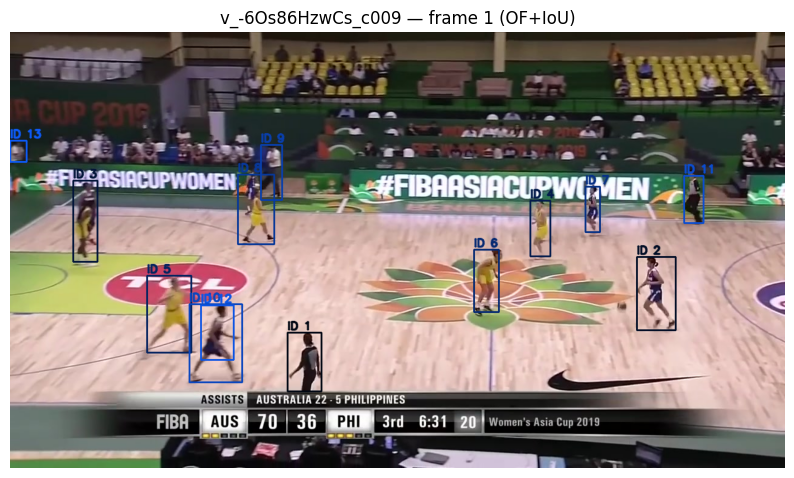

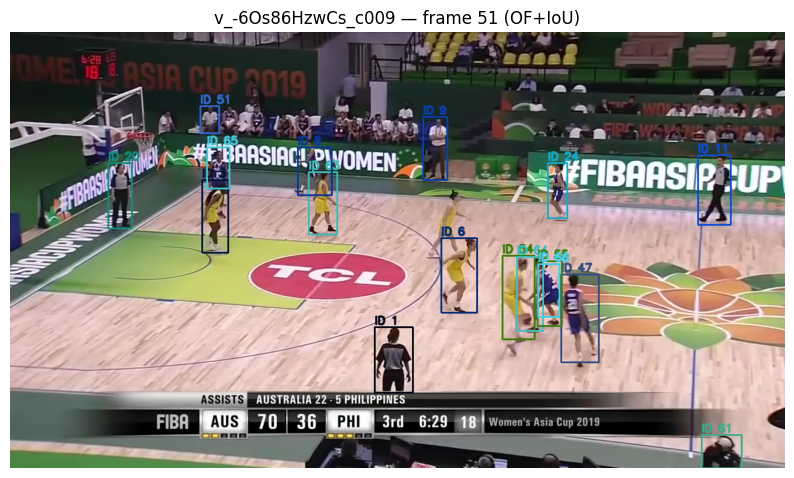

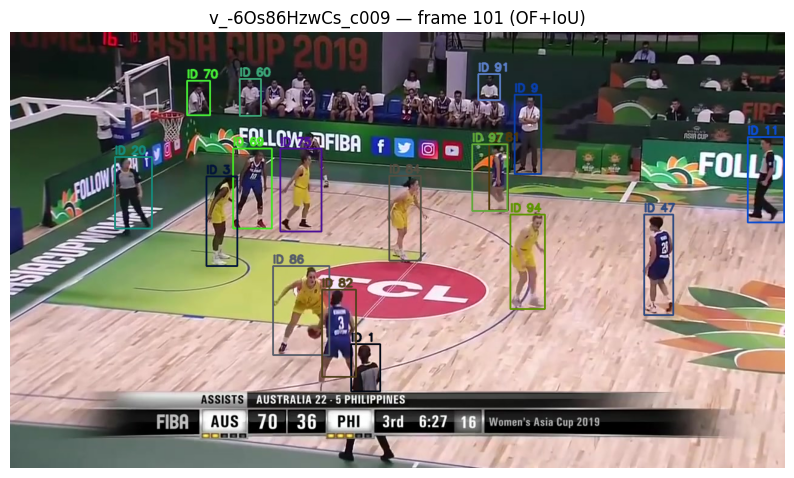

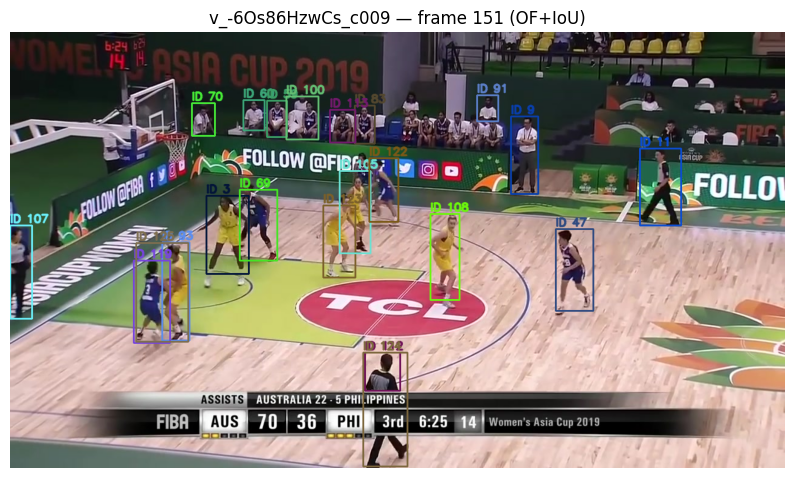

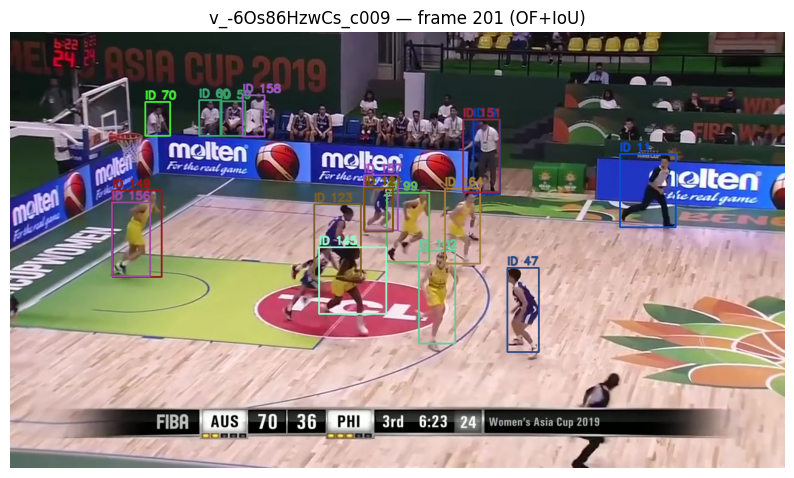

In [31]:
def visualize_tracks_on_frame(frame_path: Path,
                              tracks_df: pd.DataFrame,
                              title_suffix: str = ""):
    frame_id = int(frame_path.stem)
    img_bgr = cv2.imread(str(frame_path))
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    tr_f = tracks_df[tracks_df["frame"] == frame_id].copy()
    tr_f = tr_f.sort_values("conf", ascending=False)

    for _, row in tr_f.iterrows():
        x, y, w, h = row["x"], row["y"], row["w"], row["h"]
        tid = int(row["id"])

        color = (
            hash(tid) % 255,
            hash(tid * 7) % 255,
            hash(tid * 19) % 255,
        )
        color = tuple(int(c) for c in color)

        cv2.rectangle(img, (int(x), int(y)),
                      (int(x + w), int(y + h)),
                      color, 2)
        cv2.putText(
            img,
            f"ID {tid}",
            (int(x), int(y) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
            cv2.LINE_AA,
        )

    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{seq_name} — frame {frame_id} {title_suffix}")
    plt.show()


# Visualizar algunos frames espaciados
for fp in all_frame_paths[::50][:5]:
    visualize_tracks_on_frame(fp, tracks_of_df, title_suffix="(OF+IoU)")


## Animación: tracks con Optical Flow (incluye balón) 🎥

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML

BALL_CLASSES = {"sports ball", "ball", "basketball", "volleyball"}
ball_lower = {c.lower() for c in BALL_CLASSES}


def animate_tracks(tracks_df, frame_paths, interval=80, max_tracks=50, title='Optical Flow tracker'):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    def draw(idx):
        ax.clear()
        ax.axis('off')
        frame_path = frame_paths[idx]
        frame_id = int(frame_path.stem)
        img_bgr = cv2.imread(str(frame_path))
        if img_bgr is None:
            return []
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

        tr_f = tracks_df[tracks_df["frame"] == frame_id].copy()
        tr_f = tr_f.sort_values("conf", ascending=False).head(max_tracks)
        for _, row in tr_f.iterrows():
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]
            tid = int(row.get("id", -1))
            cls = str(row.get("cls_name", "")).lower()
            is_ball = cls in ball_lower
            color = 'red' if is_ball else 'orange'
            ax.add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none'))
            label = f"Ball ID {tid}" if is_ball else f"ID {tid}"
            ax.text(x, y-2, label, color='black', fontsize=8, bbox=dict(facecolor=color, alpha=0.4, pad=1))
        ax.set_title(f"Frame {frame_id} ({title})")
        return []

    anim = FuncAnimation(fig, draw, frames=len(frame_paths), interval=interval, blit=False)
    print(f'Generando animación de tracks ({title})...')
    html_video = HTML(anim.to_jshtml())
    plt.close(fig)
    return html_video

frame_paths = sorted(img_dir.glob('*.jpg')) or sorted(img_dir.glob('*.png'))
frame_paths = frame_paths[:120]
if not frame_paths:
    raise FileNotFoundError(f'No se encontraron frames en {img_dir}')

video_animation = animate_tracks(tracks_of_df, frame_paths, interval=80, title='Optical Flow')
video_animation
